In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
from sklearn import linear_model
from sklearn import model_selection 
import gc
import tifffile

In [10]:
# import initial image and metrics data
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_3 
    
img =cv2.imread('random_3_final_crop_masks.tif') #segmented and eroded image
metrics=pd.read_csv('exported_metrics_random_3.csv')
df=np.load('match_3.npy')


C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_3


In [114]:
df

array([[1700.,  100.,  964.,   63.,   48.],
       [2100.,  100., 1182.,   48.,   22.],
       [3300.,  100., 1843.,   68.,   59.],
       [5300.,  300., 2800.,  182.,    8.],
       [7900.,  500., 4164.,  284.,   40.],
       [1900.,  700., 1055.,  359.,    8.],
       [5300.,  900., 2751.,  476.,  118.],
       [5500.,  900., 2928.,  470.,  109.],
       [7500.,  900., 3933.,  513.,   36.],
       [3700., 1100., 1927.,  544.,  174.],
       [3900., 1100., 2190.,  599.,  201.],
       [5500., 1100., 2920.,  634.,  157.],
       [ 500., 1300.,  310.,  660.,   39.],
       [ 900., 1300.,  522.,  644.,   79.],
       [1500., 1300.,  817.,  653.,   59.],
       [3700., 1300., 1972.,  697.,   78.],
       [6700., 1300., 3531.,  710.,   20.],
       [7100., 1500., 3704.,  785.,  130.],
       [2700., 1700., 1468.,  891.,   90.],
       [3300., 1700., 1794.,  877.,   99.],
       [4900., 1700., 2609.,  895.,   99.],
       [6100., 1700., 3261.,  972.,  169.],
       [7500., 1700., 3937.,  92

In [201]:
#calculate density, del and del^2 of regions given a window size
window_radius=[200, 500, 800, 1000, 1200, 1500, 2000]
y=df[:,4]
cx=df[:,0]
cy=df[:,1]
# Find Canny edges
edged = cv2.Canny(img, 30, 200)

#contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

number_mat=np.zeros([np.shape(cx)[0],np.size(window_radius)])
density=np.zeros([np.shape(cx)[0],np.size(window_radius)])
grad=np.zeros([np.shape(cx)[0],np.size(window_radius)])
lap=np.zeros([np.shape(cx)[0],np.size(window_radius)])
for ii in range(np.shape(cx)[0]):

    repe=np.repeat([[cx[ii],cy[ii]]],np.shape(cx)[0], axis=0)
    vec=np.transpose([cx,cy])-repe
    dist=np.sqrt((cx[:]-repe[:,0])**2+(cy[:]-repe[:,1])**2)
    dist=dist[dist!=0]
    #print(dist)
    for jj in range(np.size(window_radius)):
        ids=np.argwhere(dist<window_radius[jj])
        
       
        number=np.size(ids) #include self?
        
        number_mat[ii,jj]=number
        density[ii,jj]=number#/(np.pi*window_radius[jj]**2)*100
        
        r=dist[ids]
        
        f=(1/r**2)-1
        
        grad_x=np.sum(np.multiply(f,vec[ids,0])/r)
        grad_y=np.sum(np.multiply(f,vec[ids,1])/r)
        grad[ii,jj]=np.sqrt(grad_x**2+grad_y**2)
        
        lap[ii,jj]=np.sum(f)
'''
ok=0       
while ok==0:    
    alpha=np.random.rand(1)
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(density, y)
    if np.size(np.where(clf.coef_!=0))==3:
        ok=1
'''

#model = linear_model.Lasso()
# define model evaluation method
#cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
#grid = dict()
#grid['alpha'] = np.arange(0, 0.01, 0.00001)
# define search
#search = model_selection.GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
matrix_t=np.concatenate((density, grad,lap), axis=1)
#matrix_t=density
#results = search.fit(matrix_t, y)
#print(results.best_params_)   


In [175]:
1/r-1

array([[-0.99945767],
       [-0.99949233],
       [-0.99945767],
       [-0.99823223],
       [-0.99823223],
       [-0.99937983],
       [-0.99646447],
       [-0.99646447]])

In [211]:
alpha=np.arange(0, 1, 0.00001)
chi_tot=np.zeros(np.size(alpha,0))
for ii in range(np.size(alpha,0)):
    clf = linear_model.Lasso(alpha=alpha[ii])
    clf.fit(matrix_t, y)
    a=matrix_t*clf.coef_
    chi=np.zeros(np.size(a,0))
    for jj in range(np.size(a,0)):
        chi[jj]=(np.sum(a[jj,:])-y[jj])**2/np.sum(a[jj,:])
        
    chi_tot[ii]=np.sum(chi)    


<ipython-input-211-38acd747f46d>:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  clf.fit(matrix_t, y)
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62123.96758074185, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42690.78935316692, tolerance: 24.208781176470588
  model = cd_fast.enet_coor

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9927.364815305278, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9920.117356612158, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9913.097432645998, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9702.288403807674, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9700.469314190763, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9698.680193648019, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9621.825132615151, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9621.115868843219, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9620.414418451488, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9586.509223240006, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9586.147017636351, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9585.787927814526, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9565.302291781496, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9565.107466289322, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9564.914037908151, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9553.520104908763, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9553.40534525404, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9553.291322811914, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9546.49758641822, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9546.426589014503, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9546.356021424392, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9542.109476324127, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9542.064738666624, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9542.020266805805, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9539.255636092974, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9539.227932311958, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9539.200395980239, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9537.51620754473, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9537.499228672415, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9537.482357743924, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9536.464608575785, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9536.454544897017, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9723.213527543703, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1499.034153764689, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1499.0265469787846, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1499.0240455876046, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500.2264563504577, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500.239259238966, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500.2519888961979, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1501.216716750103, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1501.2287127271557, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1501.240676477566, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.139880938339, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.1506669247028, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.1613068800652, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.920739514535, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.9298495687544, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1502.9391115097387, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1503.5484394285304, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1503.5560124659678, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1503.5633657450962, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1504.0444082999602, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1504.049831214128, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1504.055446452243, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2432.314361068158, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2430.4228043580515, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429.1108964033338, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2524.6588849245163, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525.0079087548656, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525.3283938636596, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16507.28112521182, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15742.39585142822, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15108.846041424571, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18012.08229074537, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18011.38364670507, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18010.648704380284, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12978.356451684143, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12033.018486072426, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11235.349785497514, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.89043687765661, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.459438824284, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.91339624636748, tolerance: 24.208781176470588
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

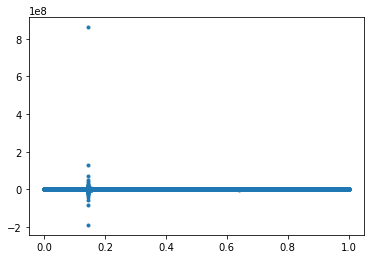

In [212]:
plt.plot(alpha,chi_tot,'.')

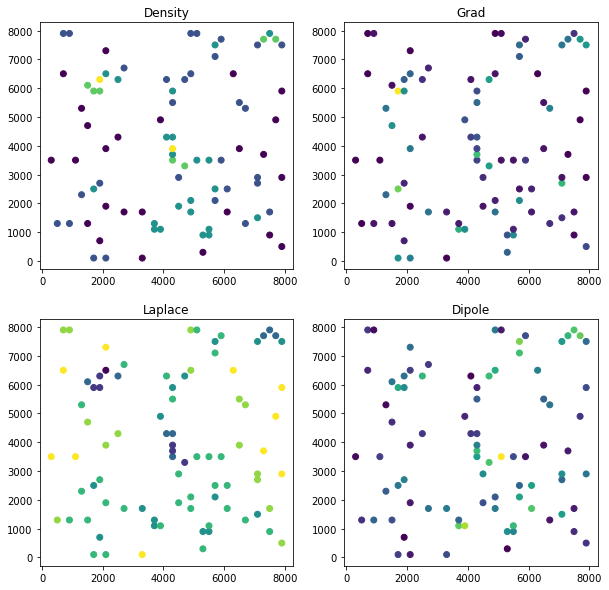

In [148]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].scatter(cx,cy,c=density[:,1])
axs[0,0].set_title('Density')
plt.gca().invert_yaxis()
axs[0,1].scatter(cx,cy,c=grad[:,2])
axs[0,1].set_title('Grad')
plt.gca().invert_yaxis()
axs[1,0].scatter(cx,cy,c=lap[:,2])
axs[1,0].set_title('Laplace')
plt.gca().invert_yaxis()
axs[1,1].scatter(cx,cy,c=y)
axs[1,1].set_title('Dipole')
plt.gca().invert_yaxis()

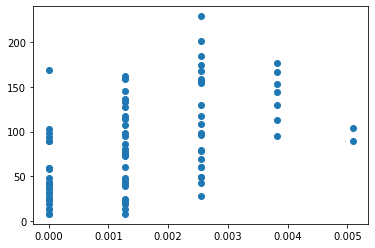

In [149]:
plt.scatter(density[:,1],y)

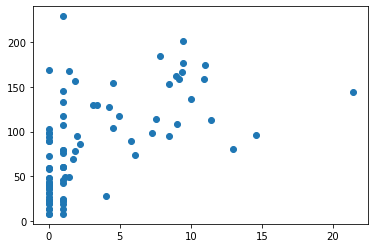

In [150]:
plt.scatter(grad[:,1],y)

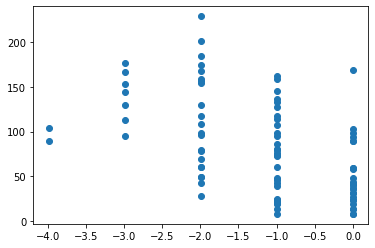

In [151]:
plt.scatter(lap[:,1],y)

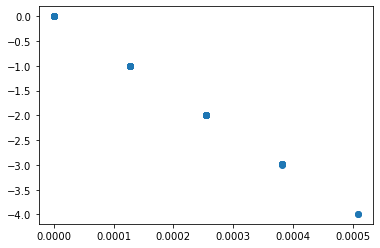

In [157]:
plt.scatter(density[:,1],lap[:,1])

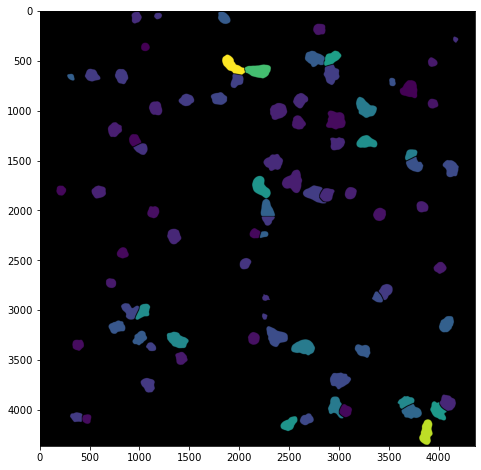

In [112]:
a=tifffile.imread('final_random_3_roi_AR.tif')
plt.figure(figsize=[8,8])
plt.imshow(a)


In [ ]:
# visualize dipole moment

im_color=np.zeros( (img.shape[0],img.shape[1]) )
 
im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=dipole_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
img = plt.imshow(im_color, cmap=cmap)

plt.colorbar(img)


<ipython-input-27-4c20c39fdb58>:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("PiYG"))
  cmap.set_bad(color = 'k', alpha = 1)


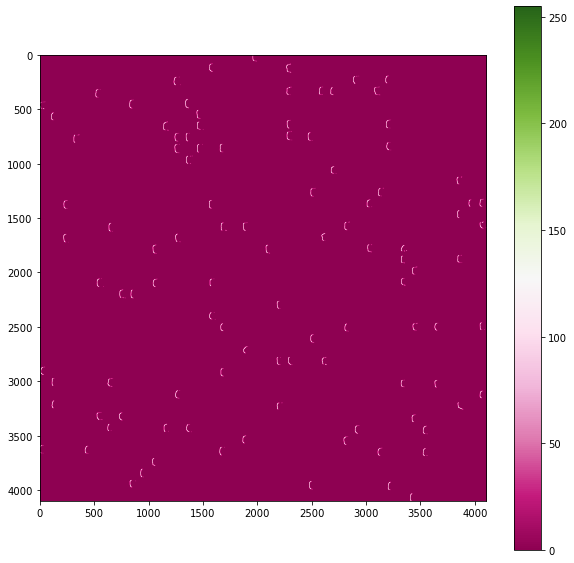

In [27]:
img =cv2.imread('random_7_init_crop_masks.tif')
np.array(img)
img.astype(float)
img_sobel=ndimage.sobel(np.array(img[:,:,0]))
img_sobel.astype(float)
#img_sobel[img_sobel==0]=np.nan
plt.figure(figsize=(10,10))
#plt.imshow(img_sobel)
cmap = plt.cm.get_cmap("PiYG")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(img_sobel, cmap=cmap)

plt.colorbar(im)

In [22]:
a=np.random.randint(2,size=[5,5])
ndimage.sobel(a)


ValueError: cannot convert float NaN to integer

In [26]:
np.unique(img)

array([  0, 255], dtype=uint8)